In [23]:
import pandas as pd
import nltk 
import re
import string
import spacy
import tensorflow
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

from nltk.stem import WordNetLemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,LSTM,Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,Input,Bidirectional,LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to C:\Users\Lyubomir
[nltk_data]     Ruzhinski\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Lyubomir
[nltk_data]     Ruzhinski\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to C:\Users\Lyubomir
[nltk_data]     Ruzhinski\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Lyubomir
[nltk_data]     Ruzhinski\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
MAX_SEQUENCE_LENGTH = 30
DROPOUT_RATE = 0.3
LEAKY_RELU_ALPHA = 0.2
KERNEL_SIZE = 5
FILTERS = 64
LSTM_UNITS = 64

In [4]:
data = pd.read_csv("data.csv",sep=',', usecols=["phrase","prompt"])
data = data.dropna()
num_classes = data['prompt'].nunique()

In [5]:
def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    
    tokens = nltk.word_tokenize(text)
    lower = [t.lower() for t in tokens]
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    stripped = [re_punc.sub('', w) for w in lower]
    words = [word for word in stripped if word.isalpha()]
    words = [w for w in words if not w in  list(STOP_WORDS)]
    words = [word for word in words if len(word) > 2]
    lem_words = [lemmatizer.lemmatize(word) for word in words]
    return lem_words

In [6]:
dataset = list(data['phrase'].apply(preprocess))
labels = list(data['prompt'])

In [7]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(dataset)
word_index = tokenizer.word_index

In [8]:
nlp = spacy.load('en_core_web_lg')
embeddings = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
   embeddings[i] = nlp(word).vector

In [10]:
model = Sequential()
model.add(
Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], 
              weights=[embeddings], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(SpatialDropout1D(DROPOUT_RATE))
model.add(Conv1D(FILTERS, kernel_size=KERNEL_SIZE, padding='same'))
model.add(LeakyReLU(alpha=LEAKY_RELU_ALPHA))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(LSTM_UNITS,dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE)))
model.add(Dense(num_classes,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

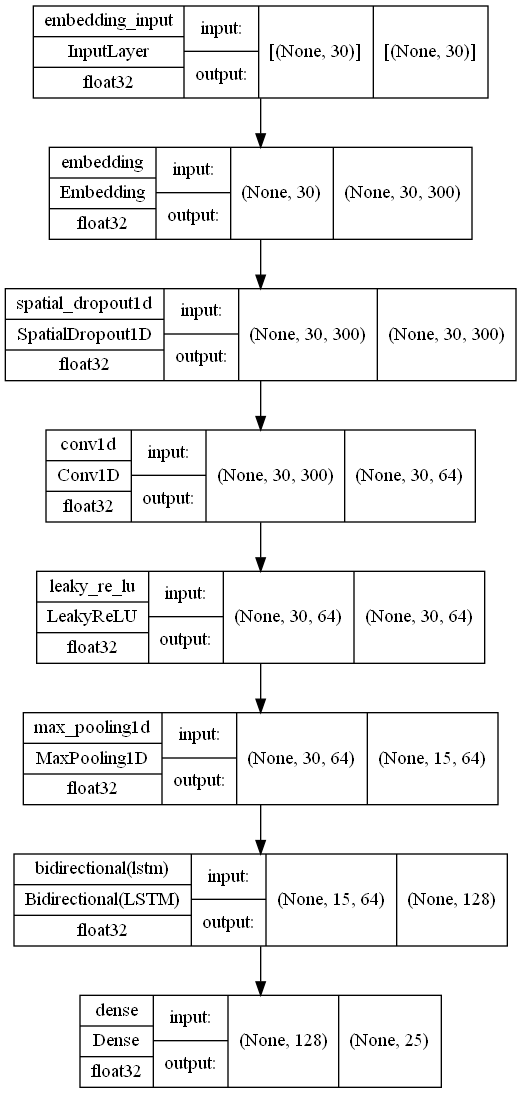

In [11]:
tensorflow.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [12]:
le = preprocessing.LabelEncoder()
le.fit(labels)
encoded_labels = le.transform(labels)

In [13]:
categorical_labels = to_categorical(encoded_labels, num_classes=num_classes)
X_train, X_test, Y_train, Y_test = train_test_split(dataset, categorical_labels, test_size=0.2, random_state=24)

In [14]:
history = model.fit(
    pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_SEQUENCE_LENGTH),
    Y_train,batch_size=32,epochs=15, 
    shuffle=True)

Epoch 1/15
167/167 [==============================] - 43s 178ms/step - loss: 1.7096 - accuracy: 0.5685
Epoch 2/15
167/167 [==============================] - 27s 162ms/step - loss: 0.4335 - accuracy: 0.8971
Epoch 3/15
167/167 [==============================] - 27s 163ms/step - loss: 0.2042 - accuracy: 0.9546
Epoch 4/15
167/167 [==============================] - 27s 163ms/step - loss: 0.1303 - accuracy: 0.9735
Epoch 5/15
167/167 [==============================] - 30s 182ms/step - loss: 0.0882 - accuracy: 0.9812
Epoch 6/15
167/167 [==============================] - 28s 170ms/step - loss: 0.0750 - accuracy: 0.9846
Epoch 7/15
167/167 [==============================] - 27s 162ms/step - loss: 0.0548 - accuracy: 0.9906
Epoch 8/15
167/167 [==============================] - 31s 185ms/step - loss: 0.0501 - accuracy: 0.9887
Epoch 9/15
167/167 [==============================] - 33s 195ms/step - loss: 0.0440 - accuracy: 0.9901
Epoch 10/15
167/167 [==============================] - 30s 177ms/step - l

In [19]:
model.evaluate(pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_SEQUENCE_LENGTH), Y_test)

42/42 [==============================] - 1s 18ms/step - loss: 0.0038 - accuracy: 1.0000


[0.0038023823872208595, 1.0]

Text(0.5, 1.0, 'Loss')

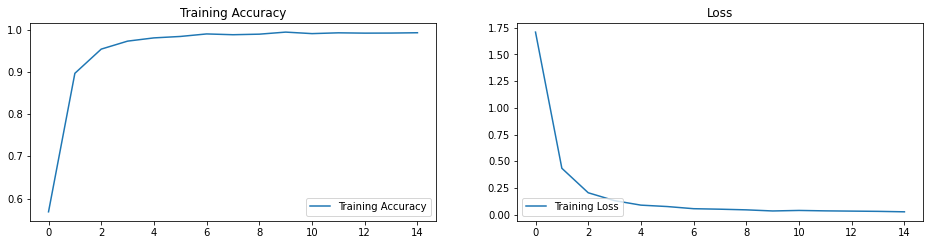

In [20]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(2,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='lower left')
plt.title('Loss')

In [21]:
model.save("trained_model")

INFO:tensorflow:Assets written to: trained_model\assets


In [24]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('labelencoder.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)